Netfile

In [1]:
from dask_jobqueue import SLURMCluster

In [7]:
cluster = SLURMCluster(queue='analysis',memory='50GB',cores=8)

In [8]:
cluster.scheduler_address

'tcp://140.208.147.178:35151'

In [11]:
cluster.close()

In [12]:
cluster

In [1]:
import cartopy
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.colorbar
import netCDF4
import numpy

In [2]:
!dmget /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_zstar/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle500/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_p25config/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_hgrid.nc
!dmget /archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_hgrid.nc
!dmget /archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_mask.nc
!dmget /archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_mask.nc
!dmget /archive/gold/datasets/OM4_025/obs/WOA05_ptemp_salt_annual.v20150310.nc
!dmget /archive/gold/datasets/OM4_05/obs/WOA05_ptemp_salt_annual.v2015.12.03.nc

In [3]:
f = 'gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc'
OM4p25 = netCDF4.Dataset(
    '/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/'+f)
OM4p25z = netCDF4.Dataset(
    '/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_zstar/'+f)
OM4p5nep = netCDF4.Dataset(
    '/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_p25config/'+f)
OM4p5mle = netCDF4.Dataset(
    '/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle500/'+f)
OM4p5 = netCDF4.Dataset(
    '/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle200/'+f)

G25 = netCDF4.Dataset('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_hgrid.nc')
G5 = netCDF4.Dataset('/archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_hgrid.nc')
M25 = netCDF4.Dataset('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_mask.nc')
M5 = netCDF4.Dataset('/archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_mask.nc')

W25 = netCDF4.Dataset('/archive/gold/datasets/OM4_025/obs/WOA05_ptemp_salt_annual.v20150310.nc')
W5 = netCDF4.Dataset('/archive/gold/datasets/OM4_05/obs/WOA05_ptemp_salt_annual.v2015.12.03.nc')

In [4]:
xq25 = G25.variables['x'][:][::2,::2]
yq25 = G25.variables['y'][:][::2,::2]
a25 = G25.variables['area'][:]; a25 = a25[::2,::2]+a25[1::2,1::2]+a25[1::2,::2]+a25[1::2,::2]
m25 = M25.variables['mask'][:]; a25 = a25*m25
xq5 = G5.variables['x'][:][::2,::2]
yq5 = G5.variables['y'][:][::2,::2]
a5 = G5.variables['area'][:]; a5 = a5[::2,::2]+a5[1::2,1::2]+a5[1::2,::2]+a5[1::2,::2]
m5 = M5.variables['mask'][:]; a5 = a5*m5

In [5]:
def stats(ax, area, anomaly, label):
    mn = (anomaly*area).sum()/area.sum()
    sd = numpy.sqrt( ((anomaly-mn)**2*area).sum()/area.sum() )
    rms = numpy.sqrt( (anomaly**2*area).sum()/area.sum() )
    qmn, qmx = anomaly.min(), anomaly.max()
    print(label, 'mean =', mn, 'sd =', sd, 'rms =', rms, 'min =', qmn, 'max =', qmx )
    bb = ax.get_position()
    plt.gcf().text(bb.x0,bb.y1+.01,'mean=%.3f$^\circ$C'%mn, horizontalalignment='left')
    plt.gcf().text(bb.x1,bb.y1+.01,'rms=%.3f$^\circ$C'%rms, horizontalalignment='right')

/nbhome/Nkeh.Boh/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6666: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


OMp25 mean = 0.13855880317787414 sd = 0.5552729952190991 rms = 0.5722994544873656 min = -5.5781364 max = 5.946973
OMp5nep mean = 0.14225300187741027 sd = 0.675308159947404 rms = 0.6901282768084877 min = -7.3153286 max = 8.089572
OMp25z mean = 0.11460595130731308 sd = 0.6085159155194044 rms = 0.6192141487040567 min = -5.6066036 max = 5.8501015
OMp5 mean = 0.143291805121631 sd = 0.6127837639377961 rms = 0.6293143053978796 min = -5.04944 max = 8.40301


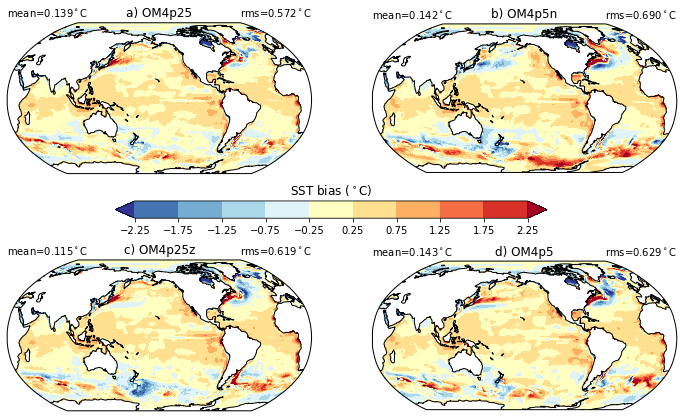

In [6]:
fig = plt.figure(figsize=(12, 8))
vmin,vmax,ci,cmap = -2.25,2.25,.5,plt.cm.RdYlBu_r
axes = []
cilev = numpy.arange(vmin-ci,vmax+ci*2,ci)
norm = matplotlib.colors.BoundaryNorm(boundaries=cilev, ncolors=cmap.N)

q = OM4p25.variables['thetao'][0,0]-W25.variables['ptemp'][0,0]
ax = fig.add_subplot(2,2,1,projection=cartopy.crs.Robinson(central_longitude=-155))
im = ax.pcolormesh(xq25, yq25, q,
              transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
stats(ax, a25, q, 'OMp25')
ax.coastlines()
axes.append(ax)
plt.title('a) OM4p25')

q = OM4p5nep.variables['thetao'][0,0]-W5.variables['ptemp'][0,0]
ax = fig.add_subplot(2,2,2,projection=cartopy.crs.Robinson(central_longitude=-155))
im = ax.pcolormesh(xq5, yq5, q,
              transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
stats(ax, a5, q, 'OMp5nep')
ax.coastlines()
axes.append(ax)
plt.title('b) OM4p5n')

q = OM4p25z.variables['thetao'][0,0]-W25.variables['ptemp'][0,0]
ax = fig.add_subplot(2,2,3,projection=cartopy.crs.Robinson(central_longitude=-155))
im = ax.pcolormesh(xq25, yq25, q,
              transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
stats(ax, a25, q, 'OMp25z')
ax.coastlines()
axes.append(ax)
plt.title('c) OM4p25z')

# q = OM4p5mle.variables['thetao'][0,0]-W5.variables['ptemp'][0,0]
# ax = fig.add_subplot(2,2,3,projection=cartopy.crs.Robinson(central_longitude=-155))
# im = ax.pcolormesh(xq5, yq5, q,
#               transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
# stats(ax, a5, q, 'OM4p5mle')
# ax.coastlines()
# axes.append(ax)
# plt.title('c) OM4p25e')

q = OM4p5.variables['thetao'][0,0]-W5.variables['ptemp'][0,0]
ax = fig.add_subplot(2,2,4,projection=cartopy.crs.Robinson(central_longitude=-155))
im = ax.pcolormesh(xq5, yq5, q,
              transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
stats(ax, a5, q, 'OMp5')
ax.coastlines()
axes.append(ax)
plt.title('d) OM4p5')

ax = plt.gcf().add_axes((.25,.5,.5,.03))
cb = matplotlib.colorbar.ColorbarBase(ax=ax, cmap=cmap, norm=norm, boundaries=cilev,
                                      orientation='horizontal', extend='both')
cb.ax.set_title('SST bias ($^\circ$C)')

plt.savefig('sst-bias.png')